In [1]:
using RHEOS
using PyPlot

# Example Notebook code

In [2]:
data = importcsv("data_time.csv", t_col=1, ϵ_col=2, σ_col=3);
# RheoTimeDataType(data)

maxwell_model = modelfit(data, Maxwell, strain_imposed, diff_method = "BD")

┌ Warning: Initial values for model parameters are set to [0.5, 0.5] by default
└ @ RHEOS C:\Users\sanja\.julia\packages\RHEOS\UUrax\src\processing.jl:250


Time: 3.6549028 s, Why: XTOL_REACHED, Parameters: [4.0054017305374146, 2.003000020980835], Error: 0.022310985023643978



Model: maxwell

Parameter values: (η = 4.0054017305374146, k = 2.003000020980835) 

                ___
            _____| |________╱╲  ╱╲  ╱╲  ___
                _|_|          ╲╱  ╲╱  ╲╱
                  η                  k
               

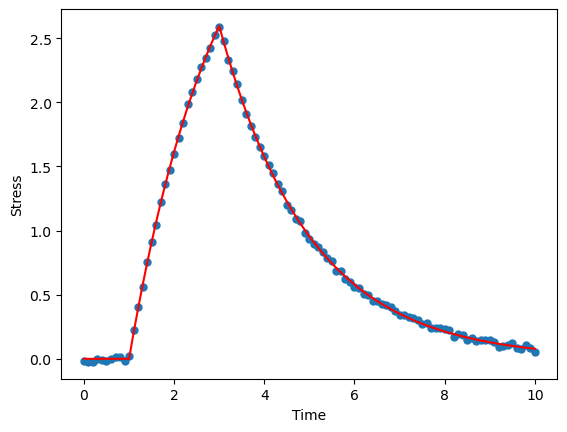

In [3]:
data_ext = extract(data,strain_only);
# alternatively: data_ext = extract(data,1);

# RheoTimeDataType(data_ext)

maxwell_predict = modelpredict(data_ext, maxwell_model, diff_method = "BD")

# Now we can plot data and model together for comparison
plot(data.t,data.σ, "o", markersize = 5);
plot(maxwell_predict.t,maxwell_predict.σ, color = "red");
xlabel("Time");
ylabel("Stress");

# Modified Maxwell

In [4]:
data = importcsv("data_time.csv", t_col=1, ϵ_col=2, σ_col=3);
RheoTimeDataType(data)

# data.ϵ;

In [5]:
?derivBD

search:

Couldn't find derivBD
Perhaps you meant div


No documentation found.

Binding `derivBD` does not exist.


In [6]:
# For some reason, wasn't able to use the derivBD and derivCD functions - maybe because they are defined in base.jl??
"""
    derivBD(y, x)
Given two arrays of data, x and y, calculate dy/dx using 1st order
backward difference. Assumes y==0 at a previous point, i.e.
y is 'at rest'. Captures instantaneous loading where derivCD will smooth.
"""
function myderivBD(y::Vector{RheoFloat}, x::Vector{RheoFloat})

    # get length
    N = length(x)

    # assert y and x arrays are same length
    @assert length(y)==N "X and Y Array lengths must match."

    # initialise zero array of length y
    ydot = similar(y)

    # assume 'imaginary' previous point is 0.0, and Δx is the same as the next one ahead
    # this is a physical assumption that material is at rest before first data point.
    # Could be problematic in some cases if sudden jump as we are actually missing
    # important information about how quickly that jump happened.
    @inbounds ydot[1] = y[1]/(x[2] - x[1])

    # backwards difference method for rest of points
    @inbounds for i in 2:N
        ydot[i] = (y[i] - y[i-1])/(x[i] - x[i-1])
    end

    return ydot

end

function myderivCD(y::Vector{RheoFloat}, x::Vector{RheoFloat})

    # get length
    N = length(x)

    # assert y and x arrays are same length
    @assert length(y)==N "X and Y Array lengths must match."

    # initialise zero array of length y
    ydot = similar(y)

    # assume 'imaginary' previous point is 0.0, and Δx is the same as the next one ahead
    # this is a physical assumption that material is at rest before first data point.
    # Could be problematic in some cases if sudden jump as we are actually missing
    # important information about how quickly that jump happened.
    @inbounds ydot[1] = y[1]/(x[2] - x[1])

    # central difference with uneven spacing for general case of constant or variable sample rate
    @inbounds for i in 2:(N-1)
        Δx₁ = x[i] - x[i-1]
        Δx₂ = x[i+1] - x[i]
        ydot[i] = (y[i+1]*Δx₁^2 + (Δx₂^2 - Δx₁^2)*y[i] - y[i-1]*Δx₂^2)/(Δx₁*Δx₂*(Δx₁ + Δx₂))
    end

    # 1st order backwards difference for last element
    ydot[N] = (y[N] - y[N-1])/(x[N] - x[N-1])

    return ydot

end


myderivCD (generic function with 1 method)

In [18]:
# my_ϵ = myderivBD(data.ϵ, data.t); # derivative is done 
my_ϵ = myderivCD(data.ϵ, data.t);

# typeof(data.ϵ)

new_data = RheoTimeData(data.σ, my_ϵ, data.t, data.log)

t =	0.0	0.1	0.2	0.3	0.4	0.5	0.6	0.7	0.8	0.9	...
ϵ =	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...
σ =	-0.0171	-0.0243	-0.0219	-0.00235	-0.0124	-0.0135	-0.00391	0.0125	0.0166	-0.0149	...


In [19]:
rMaxwell = RheoModelClass(
        # Model name
        name="rmaxwell",
        # Model parameters,
        p = [:η, :k],
        # Relaxation modulus
        G = quote 
              # k*exp(-k*t/η)

                η*(1 - exp(-k*t/η))
                
            end,
        # Creep modulus
        J = quote
              # t/η + 1/k
                (t^2/(2*η) + t/k)
            end,
        # Storage modulus
        Gp = quote # -- TODO
                denominator = 1 + η^2*ω^2/k^2
                numerator = η^2*ω^2/k
                numerator/denominator
             end,
       # Loss modulus
        Gpp = quote # -- TODO
                denominator = 1 + η^2*ω^2/k^2
                numerator = η*ω
                numerator/denominator
              end,
        # Network
        info= "
                ___
            _____| |________╱╲  ╱╲  ╱╲  ___
                _|_|          ╲╱  ╲╱  ╲╱
                  η                  k
               "
        )


Model name: rmaxwell

Free parameters: η and k

                ___
            _____| |________╱╲  ╱╲  ╱╲  ___
                _|_|          ╲╱  ╲╱  ╲╱
                  η                  k
               

In [20]:
rmaxwell_model = modelfit(new_data, rMaxwell, strain_imposed)

Time: 0.021636599 s, Why: XTOL_REACHED, Parameters: [4.047002792358398, 2.108898162841797], Error: 0.11338713640847202


┌ Warning: Initial values for model parameters are set to [0.5, 0.5] by default
└ @ RHEOS C:\Users\sanja\.julia\packages\RHEOS\UUrax\src\processing.jl:250



Model: rmaxwell

Parameter values: (η = 4.047002792358398, k = 2.108898162841797) 

                ___
            _____| |________╱╲  ╱╲  ╱╲  ___
                _|_|          ╲╱  ╲╱  ╲╱
                  η                  k
               

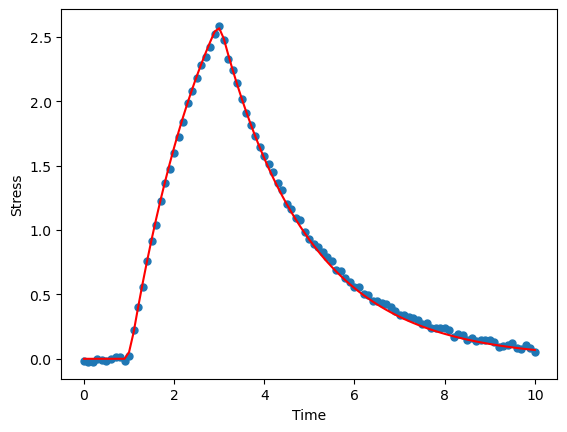

In [21]:
data_ext = extract(new_data,strain_only); # use the d(strain) for prediction
# alternatively: data_ext = extract(data,1);

# RheoTimeDataType(data_ext)

rmaxwell_predict = modelpredict(data_ext, rmaxwell_model, diff_method = "CD")
# NOTE: Getting significant differences between BD and CD

# Now we can plot data and model together for comparison
plot(data.t,data.σ, "o", markersize = 5);
# plot(rmaxwell_predict.t,myderivCD(rmaxwell_predict.σ, rmaxwell_predict.t), color = "red");
plot(rmaxwell_predict.t,rmaxwell_predict.σ, color = "red");
xlabel("Time");
ylabel("Stress");

# Modified code test - KV

In [136]:
data = importcsv("data_time.csv", t_col=1, ϵ_col=2, σ_col=3);
RheoTimeDataType(data)

strain_and_stress::TimeDataType = 3

In [137]:
my_ϵ = myderivCD(data.ϵ, data.t);
data = RheoTimeData(data.σ, my_ϵ, data.t, data.log)

t =	0.0	0.1	0.2	0.3	0.4	0.5	0.6	0.7	0.8	0.9	...
ϵ =	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...
σ =	-0.0171	-0.0243	-0.0219	-0.00235	-0.0124	-0.0135	-0.00391	0.0125	0.0166	-0.0149	...


In [138]:
KelvinVoigt_ramp =  RheoModelClass(
        # Model name
        name="KV",
        # Model parameters,
        p = [:η, :k],
        # Relaxation modulus
        G = quote
              k*t+η
            end,
        # Creep modulus
        J = quote
                (t/k) - (η/(k^2)) + (η*exp(-k*t/η)/(k^2))
              # (1 - exp(-k*t/η))/k
            end,
        # Storage modulus
        Gp = quote
                k
             end,
        # Loss modulus
        Gpp = quote
                η*ω
              end,
        # Network
        info= "
                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                "
                )


Model name: KV

Free parameters: η and k

                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                

In [139]:
kv_ramp = modelfit(data, KelvinVoigt_ramp, strain_imposed)

Time: 0.0071523 s, Why: XTOL_REACHED, Parameters: [1.183018684387207, 0.3767833709716797], Error: 36.343690628330094


┌ Warning: Initial values for model parameters are set to [0.5, 0.5] by default
└ @ RHEOS C:\Users\sanja\.julia\packages\RHEOS\UUrax\src\processing.jl:250



Model: KV

Parameter values: (η = 1.183018684387207, k = 0.3767833709716797) 

                        ___
                _________| |________
               |        _|_| η      |
           ____|                    |____
               |                    |
               |____╱╲  ╱╲  ╱╲  ____|
                      ╲╱  ╲╱  ╲╱
                                k
                

In [140]:
data_ext = extract(data,strain_only);
# alternatively: data_ext = extract(data,1);

RheoTimeDataType(data_ext)

strain_only::TimeDataType = 1

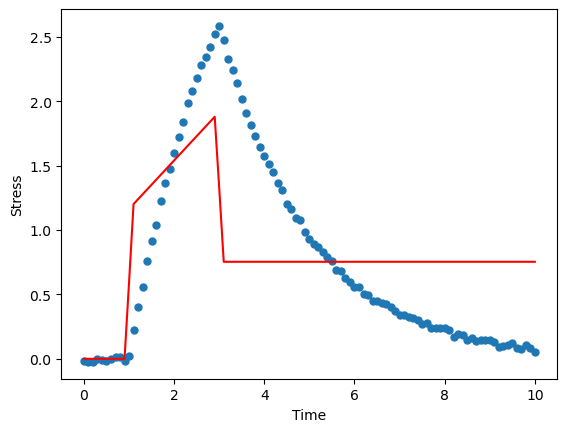

In [141]:
kv_ramp_predict = modelpredict(data_ext, kv_ramp)

# Now we can plot data and model together for comparison
plot(data.t,data.σ, "o", markersize = 5);
plot(kv_ramp_predict.t,kv_ramp_predict.σ, color = "red");
xlabel("Time");
ylabel("Stress");